## Minimum Spanning Tree Algorithm Exploration

This notebook will illustrate the application of both [Prim's Algorithm](https://en.wikipedia.org/wiki/Prim%27s_algorithm) and [Kruskal's Algorithm](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm) to solving the [Minimum Spanning Tree](https://en.wikipedia.org/wiki/Minimum_spanning_tree) problem for undirected network graphs (networks). First, we'll show how to represent undirected networks using both adjacency matrices and edge lists (as well as switching between the two representations), then we'll work through both Prim and Kruskal for each representation using the same example undirected network.

Let's start with our imports which include functions from `network_flows.py` which convert an adjacency matrix to an edge list and vice versa: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import itertools
import networkx as nx
from network_flows import *

### Preliminaries

Our example network is the same as the example provided [here](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm#Example), only we'll be replacing the vertices labeled A through G with vertices labeled 0 through 6.

We'll create an adjacency matrix by initializing an 7x7 `numpy` array of zeros (we will assume there are no zero-weight edges) where the value in i-th row and j-th column represents an edge between vertex i and vertex j. We then populate the matrix with the values of edge weights, and then "symmetrize" it (since in an undirected network if the edge (0,1) between vertices 0 and 1 exists then the edge (1,0) also exists) by adding the initially populated adjacency matrix to its transpose's lower triangualar matrix.

In [2]:
# initialize adj matrix as 7x7 array of zeros
adj = np.zeros([7,7])

# populate adj matrix with edges and their weights
adj[0][1] = 7
adj[0][3] = 5
adj[1][2] = 8
adj[1][3] = 9
adj[1][4] = 7
adj[2][4] = 5
adj[3][4] = 15
adj[3][5] = 6
adj[4][5] = 8
adj[4][6] = 9
adj[5][6] = 11

# make symmetric and check if symmetric
adj = adj + np.tril(adj.T)
print(np.allclose(adj, adj.T, rtol=1e-6, atol=1e-6))
adj

True


array([[ 0.,  7.,  0.,  5.,  0.,  0.,  0.],
       [ 7.,  0.,  8.,  9.,  7.,  0.,  0.],
       [ 0.,  8.,  0.,  0.,  5.,  0.,  0.],
       [ 5.,  9.,  0.,  0., 15.,  6.,  0.],
       [ 0.,  7.,  5., 15.,  0.,  8.,  9.],
       [ 0.,  0.,  0.,  6.,  8.,  0., 11.],
       [ 0.,  0.,  0.,  0.,  9., 11.,  0.]])

Now we'll create the list of vertices (really just the numbers 0 through 6) and use the function `make_edgelist_from_adjmatrix` from `network_flows.py` to create the an edge list from our adjacency matrix `adj`. The edge list is a dictionary where the keys are the pair of vertices connected by the edge and the values are the weights of each edge. Note that the edge list includes each edge only once (i.e., only ordered by lower-numbered vertex first but not the reverse).

In [3]:
vertices = list(range(len(adj)))
edges = make_edgelist_from_adjmatrix(adj, directed=False)
edges

{(0, 1): 7.0,
 (0, 3): 5.0,
 (1, 2): 8.0,
 (1, 3): 9.0,
 (1, 4): 7.0,
 (2, 4): 5.0,
 (3, 4): 15.0,
 (3, 5): 6.0,
 (4, 5): 8.0,
 (4, 6): 9.0,
 (5, 6): 11.0}

Let's now use `NetworkX` to draw this network graph so we have a visualization of it within this notebook to reference:

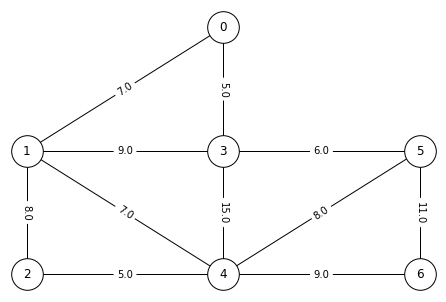

In [4]:
# Create graph object and populate edges (and by extension vertices/nodes) from our edgelist 
G1 = nx.Graph()
G1.add_weighted_edges_from([(k[0], k[1], v) for k,v in edges.items()])

# Specify positions of each node we will use to draw the network graph
G1.nodes[0]['pos'] = (0, 3)
G1.nodes[1]['pos'] = (-3, 0)
G1.nodes[2]['pos'] = (-3, -3)
G1.nodes[3]['pos'] = (0, 0)
G1.nodes[4]['pos'] = (0, -3)
G1.nodes[5]['pos'] = (3, 0)
G1.nodes[6]['pos'] = [3, -3]

# Draw the network (first its topology, then vertex and vertex labels, then edge labels)
node_pos = nx.get_node_attributes(G1,'pos')
edge_weight = nx.get_edge_attributes(G1, 'weight')
nx.draw(G1, node_pos, node_color='white')
nx.draw_networkx_nodes(G1, node_pos, node_color='white', node_size=1000, edgecolors='black')
nx.draw_networkx_labels(G1, node_pos)
nx.draw_networkx_edge_labels(G1, node_pos, edge_labels=edge_weight)
plt.ylim([-3.5, 3.5])
plt.axis('off')
plt.show()

### Kruskal's Algorithm

Now we define functions to carry out Kruskal's algorithm with a network represented first as an edgelist, then as an adjacency matrix.

Kruskal's algorithm begins with the full set of edges and each vertex treated as isolated in its own "tree," with an empty collection of edges or "forest" connecting the vertices. While there are still edges to evaluate and we have not connected all vertices (we do not have a collection of edges that are spanning), we remove the minimum weight edge at each iteration and add it to the "forest" if it connects two trees (which become part of the same tree). Once we have a spanning collection of edges or have run out of edges, we terminate and either return a minimum spanning tree (if the edges connect all the vertices) or have an unconnected network.

To help implement this we create a dictionary mapping each vertex (which we assume has a numerical value) to its current "tree." When we add an edge (i,j), the two vertices i and j, as well as any other vertex in the same tree as either i or j, are then mapped to the same "tree" which takes on the value of the lower-numbered vertex. For now, we assume the input network is connected.

The main differences between the edge list and adjacency matrix implementations are:

* We know we have run out of edges when the edge list is empty, while we need the adjacency matrix will need to be all zeros again
* We find the minimum weight edge by simply finding the minimum value weight in the edge list, but in the adjacency matrix we need to ignore all zero entries
* When we remove an edge, we simply remove it from the edge list, while we must zero out the weights in the adjacency matrix for the edge (in both directions) to "remove" it

We first evaluate our network using the edge list version of Kruskal's algorithm:

In [5]:
def kruskal_edgelist(edges, vertices):
    '''
        Given:
            edges, an edge list dictionary
            vertices, a list of numbers corresponding to vertices
        Return:
            mst, a spanning collection of edges (i.e., the edges of the minimum spanning tree)
            mst_weight, the total weight of the minimum spanning tree
    '''
    
    # initialize set of edges
    edge_list = edges.copy()
    
    # initialize set of trees (each vertex is its own tree), the minimum spanning tree as empty with zero cost
    F = {k: k for k in vertices}
    mst = []
    mst_weight = 0
    
    # while not spanning and non-empty set of edges:
    while (len(mst) < len(vertices)-1) & bool(edge_list):
        # find min weight edge
        min_weight_edge = min(edge_list, key=edge_list.get)
        
        # check if min weight edge connects two distinct trees
        if F[min_weight_edge[0]] != F[min_weight_edge[1]]:
            
            # combine the trees, now numbered by lower-number vertex in edge
            set_collapse = max(F[min_weight_edge[0]], F[min_weight_edge[1]])
            for k in F.keys():
                if F[k] == set_collapse:
                    F[k] = min(F[min_weight_edge[0]], F[min_weight_edge[1]])
            
            # add to "spanning tree" being built
            mst_weight += edge_list[min_weight_edge]
            mst.append(min_weight_edge)
        
        # remove min weight edge whether added or not
        edge_list.pop(min_weight_edge)
        
    return mst, mst_weight

In [11]:
mst_kruskal1, mst_kruskal_weight1 = kruskal_edgelist(edges, vertices)
print(mst_kruskal1)
print(mst_kruskal_weight1)

[(0, 3), (2, 4), (3, 5), (0, 1), (1, 4), (4, 6)]
39.0


Now for the adjacency matrix version of Kruskal's algorithm:

In [12]:
def kruskal_adjmatrix(adj):
    '''
        Given:
            adj, an adjacency matrix for an undirected network
        Return:
            mst, a spanning collection of edges (i.e., the edges of the minimum spanning tree)
            mst_weight, the total weight of the minimum spanning tree
    '''
    
    # initialize "set of edges"
    adj_matrix = adj.copy()
    
    # initialize set of trees (each vertex is its own tree), the minimum spanning tree as empty with zero cost
    vertices = list(range(len(adj_matrix)))
    F = {k: k for k in vertices}
    mst = []
    mst_weight = 0
    
    # while not spanning and non-empty set of edges:
    while (len(mst) < len(vertices)-1) & (not np.all(adj_matrix==0)):
        # find min weight edge
        min_weight_edge = np.unravel_index(np.where(adj_matrix != 0, adj_matrix, np.inf).argmin(), adj_matrix.shape)
        
        # check if min weight edge connects two distinct trees
        if F[min_weight_edge[0]] != F[min_weight_edge[1]]:
            
            # combine the trees, now numbered by lower-number vertex in edge
            set_collapse = max(F[min_weight_edge[0]], F[min_weight_edge[1]])
            for k in F.keys():
                if F[k] == set_collapse:
                    F[k] = min(F[min_weight_edge[0]], F[min_weight_edge[1]])
            
            # add to "spanning tree" being built
            mst_weight += adj_matrix[min_weight_edge[0], min_weight_edge[1]]
            mst.append(min_weight_edge)
        
        # "remove" min weight edge whether added or not
        adj_matrix[min_weight_edge[0], min_weight_edge[1]] = 0
        adj_matrix[min_weight_edge[1], min_weight_edge[0]] = 0
    
    return mst, mst_weight

In [14]:
mst_kruskal2, mst_kruskal_weight2 = kruskal_adjmatrix(adj)
print(mst_kruskal2)
print(mst_kruskal_weight2)

[(0, 3), (2, 4), (3, 5), (0, 1), (1, 4), (4, 6)]
39.0


We see that we have the same solution using either an edge list or adjacency matrix to represent the network. Let's check with what we get using `minimum_spanning_tree` from `NetworkX`:

In [15]:
mst_nx = nx.minimum_spanning_tree(G1)
print(mst_nx.edges())

[(0, 3), (0, 1), (1, 4), (3, 5), (2, 4), (4, 6)]


Looks like the same exact solution. Let's draw the minimum spanning tree onto the original network graph:

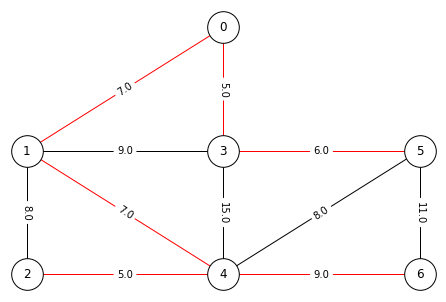

In [18]:
node_pos = nx.get_node_attributes(G1,'pos')
edge_weight = nx.get_edge_attributes(G1, 'weight')
nx.draw(G1, node_pos, node_color='white', edge_color=['red' if e in mst_nx.edges() else 'black' for e in G1.edges()])
nx.draw_networkx_nodes(G1, node_pos, node_color='white', node_size=1000, edgecolors='black')
nx.draw_networkx_labels(G1, node_pos)
nx.draw_networkx_edge_labels(G1, node_pos, edge_labels=edge_weight)
plt.ylim([-3.5, 3.5])
plt.axis('off')
plt.show()

### Prim's Algorithm

We'll define functions to carry out Prim's algorithm, again with a network represented first as an edgelist, then as an adjacency matrix.

In Prim's algorithm, we initialize the set of edges and vertices, as well as an empty tree. We start by selecting at random one vertex to initialize the tree. While there are still vertices to add, we find the minimum weight edge which connects the vertices in the tree to a vertex not in the tree. We add this edge and the associated vertex to the tree. Once we have added all vertices, then the algorithm terminates and we return the minimum spanning tree (again we assume that our input network, whether represented as an edge list or adjacency matrix, is connected). At each stage of the algorithm, we remove not just the minimum weight edge but also all the edges that connect vertices in the tree to the vertex that is about to be added.

The main differences between the edge list and adjacency matrix implementations are in the selection of the minimum weight edge and the removal of edges. With an edge list, we only need to find the minimum value weight in the edge; in an adjacency matrix, we need to use the rows of the matrix corresponding to the vertices in the current tree and then find the minimum non-zero value. As in Kruskal's algorithm, when we remove an edge, we simply remove it from the edge list, while we must zero out the weights in the adjacency matrix for the edge (in both directions) to "remove" it.

Now let's first evaluate the edge list implementation of Prim's algorithm:

In [19]:
def prim_edgelist(edges, vertices):
    '''
        Given:
            edges, an edge list dictionary
            vertices, a list of numbers corresponding to vertices
        Return:
            mst, a spanning collection of edges (i.e., the edges of the minimum spanning tree)
            mst_weight, the total weight of the minimum spanning tree
    '''
        
    # initialize set of edges and vertices
    edge_list = edges.copy()
    verts = vertices.copy()
    
    # initialize tree vertices and edges as empty and with zero weight
    F = []
    mst = []
    mst_weight = 0
    
    # select at random an initial vertex to remove and then add to the tree
    init_vert = np.random.choice(verts,1)[0]
    F.append(init_vert)
    verts.remove(init_vert)
    
    # while there are still vertices to remove and then add to the tree
    while verts:
        # find the minimum weight edge to a vertex outside the current tree, add it to the tree and remove from vertex set
        min_weight_edge = min({k:v for t in F for k, v in edge_list.items() if t in k}, key=edge_list.get)
        F.extend([min_weight_edge[0], min_weight_edge[1]])
        verts = set(verts).difference(set(F))
        F = list(set(F))
        
        # add minimum weight edge to tree
        mst.append(min_weight_edge)
        mst_weight += edge_list[min_weight_edge]
        
        # remove minimum weight edge, and all edges connecting current tree to added vertex, from list of edges 
        mst_poss_edges = itertools.combinations(F, 2)
        for edge in mst_poss_edges:
            try:
                edge_list.pop(edge)
            except:
                continue
                
    return mst, mst_weight

In [21]:
mst_prim1, mst_prim_weight1 = prim_edgelist(edges, vertices)
print(mst_prim1)
print(mst_prim_weight1)

[(2, 4), (1, 4), (0, 1), (0, 3), (3, 5), (4, 6)]
39.0


This matches up with what we got using Kruskal's. Now let's see what happens with the adjacency matrix version of Prim's algorithm:

In [34]:
def prim_adjmatrix(adj):
    '''
        Given:
            adj, an adjacency matrix for an undirected network
        Return:
            mst, a spanning collection of edges (i.e., the edges of the minimum spanning tree)
            mst_weight, the total weight of the minimum spanning tree
    '''
    
    # initialize "set of edges" and vertices
    adj_matrix = adj.copy()
    vertices = list(range(len(adj_matrix)))
    
    # initialize tree vertices and edges as empty and with zero weight
    F = []
    mst = []
    mst_weight = 0
    
    # select at random an initial vertex to remove and then add to the tree
    init_vert = np.random.choice(vertices,1)[0]
    F.append(init_vert)
    vertices.remove(init_vert)
    
    # while there are still vertices to remove and then add to the tree
    while vertices:
        # find the minimum weight edge to a vertex outside the current tree, add it to the tree and remove from vertex set
        min_weight_edge = np.unravel_index(np.where(adj_matrix[F,:] != 0, adj_matrix[F,:], np.inf).argmin(), adj_matrix[F,:].shape)        
        F.append(min_weight_edge[1])
        vertices.remove(min_weight_edge[1])
        
        # add minimum weight edge to tree
        mst.append((F[min_weight_edge[0]], min_weight_edge[1]))
        mst_weight += adj_matrix[F[min_weight_edge[0]], min_weight_edge[1]]
        
        # remove minimum weight edge from list of edges
        adj_matrix[F[min_weight_edge[0]], min_weight_edge[1]] = 0
        adj_matrix[min_weight_edge[1], F[min_weight_edge[0]]] = 0
        
        # remove all other edges connecting current tree to added vertex, from list of edges 
        F = sorted(F)
        mst_poss_edges = itertools.combinations(F, 2)
        edges_make_ineligible = [b for b in mst_poss_edges if adj_matrix[b[0], b[1]] != 0]
        for edge in edges_make_ineligible:
            adj_matrix[edge[0], edge[1]] = 0
            adj_matrix[edge[1], edge[0]] = 0
            
    return mst, mst_weight

In [35]:
mst_prim2, mst_prim_weight2 = prim_adjmatrix(adj)
print(mst_prim2)
print(mst_prim_weight2)

[(0, 3), (3, 5), (0, 1), (1, 4), (4, 2), (4, 6)]
39.0


Again, we get the same minimum spanning tree!

### Another Example

Now let's just work through another example network, first represented as an edge list and then transformed into a adjacency matrix using `make_adjmatrix_from_edgelist` from `network_flows.py`:

In [36]:
edges2 = {
    (0, 1): 4,
    (0, 7): 8,
    (1, 2): 8,
    (1, 7): 11,
    (2, 3): 7,
    (2, 5): 4,
    (2, 8): 2,
    (3, 4): 9,
    (3, 5): 14,
    (4, 5): 10,
    (5, 6): 2,
    (6, 7): 1,
    (6, 8): 6,
    (7, 8): 7
}
vertices2 = list(range(9))
vertices2

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [37]:
adj2 = make_adjmatrix_from_edgelist(len(vertices2), edges2, directed=False)
print(np.allclose(adj2, adj2.T, rtol=1e-6, atol=1e-6))
adj2

True


array([[ 0.,  4.,  0.,  0.,  0.,  0.,  0.,  8.,  0.],
       [ 4.,  0.,  8.,  0.,  0.,  0.,  0., 11.,  0.],
       [ 0.,  8.,  0.,  7.,  0.,  4.,  0.,  0.,  2.],
       [ 0.,  0.,  7.,  0.,  9., 14.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  9.,  0., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  4., 14., 10.,  0.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  6.],
       [ 8., 11.,  0.,  0.,  0.,  0.,  1.,  0.,  7.],
       [ 0.,  0.,  2.,  0.,  0.,  0.,  6.,  7.,  0.]])

So we've now created a new network as a list of edges (and vertices) and created a valid (symmetric) adjacency matrix out of it. Let's now use `NetworkX` to draw this network and find and draw its minimum spanning tree:

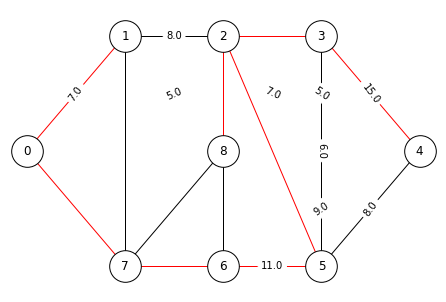

In [38]:
# Create graph object and populate edges (and by extension vertices/nodes) from our edgelist 
G2 = nx.Graph()
G2.add_weighted_edges_from([(k[0], k[1], v) for k,v in edges2.items()])

# Specify positions of each node we will use to draw the network graph
G2.nodes[0]['pos'] = (0, 0)
G2.nodes[1]['pos'] = (2, 2)
G2.nodes[2]['pos'] = (4, 2)
G2.nodes[3]['pos'] = (6, 2)
G2.nodes[4]['pos'] = (8, 0)
G2.nodes[5]['pos'] = (6, -2)
G2.nodes[6]['pos'] = (4, -2)
G2.nodes[7]['pos'] = (2, -2)
G2.nodes[8]['pos'] = (4, 0)

# Get minimum spanning tree
mst_nx2 = nx.minimum_spanning_tree(G2)

# Draw the network (first its topology, then vertex and vertex labels, then edge labels)
node_pos = nx.get_node_attributes(G2,'pos')
edge_weight = nx.get_edge_attributes(G1, 'weight')
nx.draw(G2, node_pos, node_color='white', edge_color=['red' if e in mst_nx2.edges() else 'black' for e in G2.edges()])
nx.draw_networkx_nodes(G2, node_pos, node_color='white', node_size=1000, edgecolors='black')
nx.draw_networkx_labels(G2, node_pos)
nx.draw_networkx_edge_labels(G2, node_pos, edge_labels=edge_weight)
plt.ylim([-2.5, 2.5])
plt.axis('off')
plt.show()

Now let's see what we get with Prim's algorithm:

In [40]:
prim_edgelist(edges2, vertices2)

([(0, 1), (0, 7), (6, 7), (5, 6), (2, 5), (2, 8), (2, 3), (3, 4)], 37)

In [46]:
prim_adjmatrix(adj2)

([(3, 2), (2, 8), (2, 5), (5, 6), (6, 7), (2, 1), (1, 0), (3, 4)], 37.0)

And with Kruskal's algorithm:

In [47]:
kruskal_edgelist(edges2, vertices2)

([(6, 7), (2, 8), (5, 6), (0, 1), (2, 5), (2, 3), (0, 7), (3, 4)], 37)

In [48]:
kruskal_adjmatrix(adj2)

([(6, 7), (2, 8), (5, 6), (0, 1), (2, 5), (2, 3), (0, 7), (3, 4)], 37.0)

Looks like everything checks out -- and now we're done.